Template for downloading/uploading. Because I used not cloud PC for cifar100 experiments, it has only 'pass'

In [12]:
def download_model(source_name, saving_name):
    pass

def upload_model(source_name, saving_name):
    pass

def upload_logs():
    pass

Libs importing

In [8]:
import gc
import os
import datetime

import numpy as np
np.random.seed(42)

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils as utils
from torch.utils.data import Subset, ConcatDataset, DataLoader

from PIL import Image
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from sklearn.metrics import accuracy_score

from resnet import resnet20, BasicBlock, _weights_init, resnet32, resnet56, resnet44, ResNet

def resnet7():return ResNet(BasicBlock, [1, 1, 1])

Models declaration

In [9]:
class ResNetModified(nn.Module):
    def __init__(self, block, num_blocks, input_channels, num_classes=10):
        super(ResNetModified, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def resnet7():return ResNetModified(BasicBlock, [1, 1, 1], 3, 100)
def resnet20():return ResNetModified(BasicBlock, [3, 3, 3], 3, 100)
def resnet32():return ResNetModified(BasicBlock, [5, 5, 5], 3, 100)

Declaration of utils

In [15]:
class AverageMeter:
  """Class for computing average values
  """    
  def __init__(self):
    """Init class
    """      
    self.sum_ = 0
    self.count = 0
  
  def update(self, val, count=1):
    """Add new value to track
    
    Arguments:
        val {float} -- new value
    
    Keyword Arguments:
        count {int} -- weigth of val (default: {1})
    """      
    self.sum_ += val
    self.count += count

  def average(self):
    """return average value for given values
    """      
    return self.sum_ / self.count

In [16]:
class TensorBoardLogger:
    """Class for logging into TensorBoard
    """    
    def __init__(self, log_dir, dataset, net, experiment_name):
        """Init logger
        
        Arguments:
            log_dir {string} -- log dir
            dataset {string} -- name of dataset
            experiment_name {string} -- name of experiment
        """        
        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        log_dir_full = os.path.join(log_dir, dataset, net, experiment_name, current_time)
        self.writer = tf.summary.create_file_writer(log_dir_full)
        self.step_ = 0
        
    def log_scalar(self, tag, value, step=None, description=None):
        """Log scalar
        
        Arguments:
            tag {string} -- name of variable to log
            value {float} -- value of variable
        
        Keyword Arguments:
            step {int} -- current epoch number (default: {None})
            description {string} -- [description] (default: {None})
        """        
        if step is None:
            step = self.step_
        with self.writer.as_default():
            tf.summary.scalar(tag, value, step=step, description=description)
            
    def step(self):
        """Increase epoch number by 1
        """        
        self.step_+=1

    def log_hparams(self, hparams):
        """log hparams
        
        Arguments:
            hparams {dict} -- dict to log
        """      
        with self.writer.as_default():
            hp.hparams(hparams)
        

Dataset declaration

In [4]:
batch_size = 64
dataset_name = "cifar100_aug_cached"


In [5]:
# function for dataset
def collate_fn(batch):
  imgs = [i[0] for i in batch]
  labels = [i[1] for i in batch]
  return imgs, labels

In [10]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

# augmentation and normaliztion for training
transform_train = transforms.Compose(
    [
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomCrop(32, 4),
     transforms.ToTensor(),
     normalize
     ])

# only normalization for testing
transform_test = transforms.Compose(
    [
     transforms.ToTensor(),
     normalize
     ])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, 
                                        # transform=transform_train
                                        )
valset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True,
                                      #  transform=transform_test
                                      )
# split trainvalset into val and train
idx = np.arange(len(trainset))
split = int(len(trainset)*0.15)
np.random.seed(42) # set seed to reproduce given set
np.random.shuffle(idx)
train_idx = idx[split:]
val_idx = idx[:split]

trainset = Subset(trainset, train_idx)
valset = Subset(valset, val_idx)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2,
                                          pin_memory=True, 
                                          collate_fn=collate_fn,
                                          )
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2,
                                          pin_memory=True, 
                                          collate_fn=collate_fn,
                                          )

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True,
                                      #  transform=transform_test
                                       )
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2,
                                         pin_memory=True, 
                                         collate_fn=collate_fn,
                                         )

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


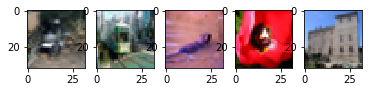

In [11]:
# show dataset images
for k, i in enumerate(trainset, 1):
  plt.subplot(1, 5, k)
  plt.imshow(i[0])
  
  if k==5:
    break

In [20]:
# check the first index, to check that trainval set splitted correctly
assert val_idx[0]==33553, "invalid val set" 

Training functions definition

In [21]:
def accuracy_minibatch(outputs, labels):
  """Compute accuracy for batch
  
  Arguments:
      outputs {list or np.array or torch.Tensor} -- outputs from model (vectors of probabilities)
      labels {list or np.array or torch.Tensor} -- labels (one number for each sample)
  
  Returns:
      float -- accuracy for minibatch
  """  
  if isinstance(outputs, torch.Tensor):
    outputs = outputs.cpu().detach().numpy()
  if isinstance(labels, torch.Tensor):
    labels = labels.cpu().detach().numpy()
  
  predict_= np.argmax(outputs, axis=1)
  true_labels_= labels
  micro_acc_score = accuracy_score(predict_, true_labels_)
  return micro_acc_score

In [15]:
def validate(net, testloader, logger=None, verbose=True, prename="val",
             cuda=True,
             transform_tensor=transform_test,
             transform_repeats=1
             ):
  """Function for compute metrics on validation set
  
  Arguments:
      net {torch net} -- model
      testloader {DataLoader} -- set to validation
      
  Keyword Arguments:
      logger {TensorBoardLogger} -- logger (default: {None})
      verbose {bool} -- show metrics (default: {True})
      prename {string} -- prename to name of metric (default: {"val"})
      cuda {bool} -- use cuda or not (default: {True})
      transform_tensor {[type]} -- transformation for image (default: {transform_test})
      transform_repeats {int} -- amount of repeats (default: {1})
  
  Returns:
      [dict] -- scores for computing metrics
  """  
  # change net to evaluation mode
  net.eval()
  ce_loss_avg = AverageMeter()
  accuracy_score_avg = AverageMeter()
  criterion = nn.CrossEntropyLoss()
  
  # evaluate dataset
  for i, data in enumerate(testloader, 0):
    inputs, labels = data
    labels = torch.tensor(labels)

    if cuda:
      labels = labels.cuda()

    inputs_ = [torch.stack([transform_tensor(j) for j in inputs]) for i in range(transform_repeats)]

    current_batch_size = len(labels)

    outputs = 0
    for i in range(transform_repeats):
        outputs += net(inputs_[i].cuda() if cuda else inputs_[i])
    outputs/=transform_repeats

    loss = criterion(outputs, labels).cpu().detach().numpy()
    
    micro_acc_score = accuracy_minibatch(outputs, labels)

    accuracy_score_avg.update(micro_acc_score*current_batch_size, current_batch_size)
    ce_loss_avg.update(loss.item()*current_batch_size, current_batch_size)

  accuracy = accuracy_score_avg.average()
  ce_loss = ce_loss_avg.average()
  scores = {
      "%s_accuracy"%prename: accuracy,
      "%s_overall_loss"%prename: ce_loss,
       }
  
  # log scores
  for name, score in scores.items():
    if logger:
      logger.log_scalar(name, score)
    if verbose:
      print(name, score)
  
  if verbose:
    print("__________________")
  # change net to training mode
  net.train()
  return scores

In [32]:
def train_distillation_cached(
    net_student, 
    trainloader, 
    testloader, 
    logger=None,
    cuda=True,
    epoches=150,
    verbose=True, 
    return_best=False,
    init_lr=0.1,
    temperature=1,
    cos_alpha=0,
    l_alpha=0,
    p=2,
    shuffle=True,
    wd=1e-4,
    transform_tensor=transform_train
    ):
  """Training using knowledge distillation approach
  
  Arguments:
      net_student {torch model} -- student model
      trainloader {list} -- cached train set
      testloader {DataLoader} -- test set
  
  Keyword Arguments:
      logger {TensorBoardLogger} -- logger (default: {None})
      compression_f {function} -- function to preprocess input (default: {None})
      epoches {int} -- epochs to train (default: {150})
      verbose {bool} -- show metrics (default: {True})
      return_best {bool} -- return best model (default: {False})
      init_lr {float} -- initial learning rate (default: {0.1})
      temperature {int} -- temperature (default: {1})
      cos_alpha {float} -- coefficeint of combining distillation (KL) and cosine disimilarity loss (default: {0})
      shuffle {bool} -- shuffle dataset each epoch (default: {True})
      temperature {int} -- temperature (default: {1})
      l_alpha {float} -- coefficeint of L^p loss in distillation loss (default: {0.0})
      p {int} -- parametr for L^p loss (default: {2})
  
  Returns:
      torch model -- best or last model
  """  
  # change net to training mode
  net_student.train()
  net_teacher.eval()
  # use gpu to train
  net_student.cuda()

  criterion_ce = nn.CrossEntropyLoss().cuda()
  criterion_nll = nn.NLLLoss().cuda()
  criterion_bce = nn.BCELoss().cuda() 
  criterion_kl = nn.KLDivLoss(reduction="batchmean").cuda()
  cosine_similarity = nn.CosineSimilarity(dim=1, eps=1e-6)
  criterion_mse = nn.MSELoss()
  criterion_mae = nn.L1Loss()

  optimizer = torch.optim.SGD(
      net_student.parameters(), 
      lr=init_lr,
      momentum=0.9,
      weight_decay=wd
      )
  # optimizer = torch.optim.Adam(
  #     net_student.parameters(), )
  # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.001, patience=patience, eps=1e-5)
  scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [80, 105, 125, 140])

  validation_scores = []
  os.makedirs("models", exist_ok=True)
  saving_path_template = "models/model_epoch%s.dms"

  for epoch in range(epoches):  # loop over the dataset multiple times
    saving_name = saving_path_template%epoch
    
    loss_avg = AverageMeter()
    accuracy_score_avg = AverageMeter()
    loss_kl_avg = AverageMeter()
    loss_cos_dis_avg = AverageMeter()
    loss_ce_avg = AverageMeter()

    if shuffle:
      np.random.shuffle(trainloader)

    for i, data in enumerate(trainloader, 1):
        # get the inputs; data is a list of [inputs, labels]
        inputs_pil, out_teacher, labels = data
        current_batch_size = len(out_teacher)

        inputs = torch.stack([transform_tensor(j) for j in inputs_pil])
        inputs, out_teacher = inputs.cuda(), out_teacher.cuda()

        if cuda:
          inputs, labels = inputs.cuda(), labels.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        out_student = net_student(inputs)
        soft_log_probs = F.log_softmax(out_student / temperature, dim=1)
        soft_output = F.softmax(out_student / temperature, dim=1)
        soft_targets = out_teacher#F.softmax(out_teacher / temperature, dim=1)
        
        kl_loss = criterion_kl(soft_log_probs, soft_targets.detach())
        cos_dis_loss =  (1 - cosine_similarity(out_student - torch.mean(out_student, dim=1, keepdim=True), out_teacher.detach() - torch.mean(out_teacher.detach(), dim=1, keepdim=True))).mean()
        
        l_loss = (torch.abs(out_student - out_teacher)**p).mean()**(1/p)

        loss = (1 - cos_alpha - l_alpha) * kl_loss + cos_alpha * cos_dis_loss + l_alpha * l_loss
        loss.backward()
        optimizer.step()

        micro_acc_score = accuracy_minibatch(out_student, labels)

        loss_avg.update(loss.item()*current_batch_size, current_batch_size)
        accuracy_score_avg.update(micro_acc_score*current_batch_size, current_batch_size)
        loss_kl_avg.update(kl_loss.item()*current_batch_size, current_batch_size)
        loss_cos_dis_avg.update(cos_dis_loss.item()*current_batch_size, current_batch_size)
        # loss_ce_avg.update(loss_ce.item()*current_batch_size, current_batch_size)
        
    if verbose:
        print(saving_name)
        print('overall loss {:.3}'.format(loss_avg.average()))
        print('current lr {:.3e}'.format(optimizer.param_groups[0]['lr']))
        print("__________________")
    # clear memory 
    gc.collect()
    torch.cuda.empty_cache()  
    
    # save scores to take best model in the future
    validation_score = validate(net_student, valloader, 
                                logger=logger, 
                                verbose=verbose, 
                                )
    accuracy = validation_score['val_accuracy']
    validation_scores.append(accuracy)
    # save model
    torch.save(net_student.state_dict(), saving_name)

    if logger:
        logger.log_scalar("overall_loss", loss_avg.average())
        logger.log_scalar("accuracy", accuracy_score_avg.average())
        logger.log_scalar("kl_loss", loss_kl_avg.average())
        logger.log_scalar("cos_dis_loss", loss_cos_dis_avg.average())
        logger.step()
    scheduler.step()
    
  best_epoch = np.argmax(validation_scores)
  if return_best:
    choosen_epoch = best_epoch
  else:
    choosen_epoch = epoch
  if verbose:
    print("choosen epoch:", choosen_epoch, ", score:", validation_scores[choosen_epoch])
    print("best epoch:", best_epoch, ", score:", validation_scores[best_epoch])
  model_name = saving_path_template%choosen_epoch
  net_student.load_state_dict(torch.load(model_name))
  return net_student

In [34]:
def cache_loader(net_teacher, loader, cuda=True,
                 transform_tensor=transform_train,
                 transform_repeats=4
                 ):
  """Cache loader, to prevent computing teacher model output
  
  Arguments:
      net_teacher {torch model} -- teacher model
      loader {DataLoader} -- dataset to cache
  
  Keyword Arguments:
      cuda {bool} -- use cuda or not(default: {True})
      transform_tensor {func} -- image transformation (default: {transform_train})
      transform_repeats {int} -- amount of repeats (default: {int})
  
  Returns:
      List -- List of (inputs, teacher model outputs)
  """  
  net_teacher.eval()
  cached = []
  for inputs_pil, labels in loader:
    labels = torch.tensor(labels)
    if cuda:
      labels = labels.cuda()

    inputs_ = [torch.stack([transform_tensor(j) for j in inputs_pil]) for i in range(transform_repeats)]

    outputs = 0
    for i in range(transform_repeats):
        outputs += F.softmax(net_teacher(inputs_[i].cuda() if cuda else inputs_[i]),dim=1)
    outputs/=transform_repeats

    cached.append([inputs_pil, outputs.cpu().detach(), labels.cpu().detach()])

  return cached

In [28]:
def validate_loader(loader):
  accuracy_score_avg = AverageMeter()
  for data in loader:
    inputs_pil, out_teacher, labels = data

    current_batch_size = len(labels)

    micro_acc_score = accuracy_minibatch(out_teacher, labels)

    accuracy_score_avg.update(micro_acc_score*current_batch_size, current_batch_size)
  print(accuracy_score_avg.average())

In [35]:
for i in range(1):
  for net_teacher, net_student, teacher_name, student_name in [
                    (resnet20(), resnet7(), "resnet20_classic.pt", ""), 
                    ]:

    epochs = 150
    download_model(teacher_name, teacher_name)
    state_dict_teacher = torch.load(teacher_name)
    net_teacher.cuda().load_state_dict(state_dict_teacher)
    loader_cached = cache_loader(net_teacher, trainloader, transform_repeats=8, transform_tensor=transform_train)

    experiment_name = teacher_name[:8]+"aug_kl_soft.pt"
    logger = TensorBoardLogger("logs", dataset_name, "resnet7", experiment_name)
    net_student = train_distillation_cached(
                              net_student,
                              loader_cached,
                              valloader,
                              epoches=epochs, 
                              init_lr=1e-1, 
                              logger=logger,
                              return_best=True,
                              cos_alpha=0.0,
                              l_alpha=0.0,
                              p=2,
                              wd=1e-4,
                              temperature=1, 
                              transform_tensor=transform_train
                              )

    print("-----------------")
    print("*****************")
    print(experiment_name)
    score_test = validate(net_student, testloader, prename='test')
    score_val = validate(net_student, valloader, prename='val')
    score_train=validate(net_student, trainloader, prename='train')

    print("----------------")
    score_teacher_test = validate(net_teacher, testloader, prename='test')
    score_teacher_val = validate(net_teacher, valloader, prename='val')
    score_teacher_train = validate(net_teacher, trainloader, prename='train')
    print("----------------")

    hparams = {"experiment_name":experiment_name, "teacher":teacher_name, "dataset":dataset_name}
    for key, value in score_val.items():
      hparams["student/"+key] = value
    for key, value in score_test.items():
      hparams["student/"+key] = value
    for key, value in score_train.items():
      hparams["student/"+key] = value
    
    for key, value in score_teacher_test.items():
      hparams["teacher/"+key] = value
    for key, value in score_teacher_val.items():
      hparams["teacher/"+key] = value
    for key, value in score_teacher_train.items():
      hparams["teacher/"+key] = value

    logger.log_hparams(hparams) 

    torch.save(net_student.state_dict(), experiment_name)

    saving_path_template = "models/model_epoch%s.dms"
    logger.step_=0
    

models/model_epoch0.dms
overall loss 2.93
current lr 1.000e-01
__________________
val_accuracy 0.13146666666666668
val_overall_loss 3.686241738510132
__________________
models/model_epoch1.dms
overall loss 2.26
current lr 1.000e-01
__________________
val_accuracy 0.188
val_overall_loss 3.480246533584595
__________________
models/model_epoch2.dms
overall loss 1.89
current lr 1.000e-01
__________________
val_accuracy 0.2596
val_overall_loss 3.0644939549764
__________________
models/model_epoch3.dms
overall loss 1.66
current lr 1.000e-01
__________________
val_accuracy 0.32053333333333334
val_overall_loss 2.6408280564626057
__________________
models/model_epoch4.dms
overall loss 1.5
current lr 1.000e-01
__________________
val_accuracy 0.3430666666666667
val_overall_loss 2.7194862674713134
__________________
models/model_epoch5.dms
overall loss 1.39
current lr 1.000e-01
__________________
val_accuracy 0.36093333333333333
val_overall_loss 2.6138981811523436
__________________
models/model_e

val_accuracy 0.49173333333333336
val_overall_loss 1.9752811030069988
__________________
models/model_epoch50.dms
overall loss 0.793
current lr 1.000e-01
__________________
val_accuracy 0.5081333333333333
val_overall_loss 1.8645990374247232
__________________
models/model_epoch51.dms
overall loss 0.795
current lr 1.000e-01
__________________
val_accuracy 0.5058666666666667
val_overall_loss 1.9029313154856364
__________________
models/model_epoch52.dms
overall loss 0.797
current lr 1.000e-01
__________________
val_accuracy 0.4573333333333333
val_overall_loss 2.2536935240427654
__________________
models/model_epoch53.dms
overall loss 0.788
current lr 1.000e-01
__________________
val_accuracy 0.5158666666666667
val_overall_loss 1.8235832098007203
__________________
models/model_epoch54.dms
overall loss 0.788
current lr 1.000e-01
__________________
val_accuracy 0.4898666666666667
val_overall_loss 1.9756272556304932
__________________
models/model_epoch55.dms
overall loss 0.79
current lr 1.0

val_accuracy 0.6010666666666666
val_overall_loss 1.470864688237508
__________________
models/model_epoch99.dms
overall loss 0.517
current lr 1.000e-02
__________________
val_accuracy 0.5981333333333333
val_overall_loss 1.4751247268040975
__________________
models/model_epoch100.dms
overall loss 0.516
current lr 1.000e-02
__________________
val_accuracy 0.5945333333333334
val_overall_loss 1.466208149210612
__________________
models/model_epoch101.dms
overall loss 0.511
current lr 1.000e-02
__________________
val_accuracy 0.5978666666666667
val_overall_loss 1.4773006734848022
__________________
models/model_epoch102.dms
overall loss 0.51
current lr 1.000e-02
__________________
val_accuracy 0.5965333333333334
val_overall_loss 1.4749180212656656
__________________
models/model_epoch103.dms
overall loss 0.512
current lr 1.000e-02
__________________
val_accuracy 0.5982666666666666
val_overall_loss 1.4708130274454752
__________________
models/model_epoch104.dms
overall loss 0.51
current lr 1.

models/model_epoch148.dms
overall loss 0.477
current lr 1.000e-05
__________________
val_accuracy 0.6036
val_overall_loss 1.4443852114359539
__________________
models/model_epoch149.dms
overall loss 0.477
current lr 1.000e-05
__________________
val_accuracy 0.6046666666666667
val_overall_loss 1.4421348145167032
__________________
choosen epoch: 122 , score: 0.6084
best epoch: 122 , score: 0.6084
-----------------
*****************
resnet20aug_kl_soft.pt
test_accuracy 0.6027
test_overall_loss 1.4309605567932129
__________________
val_accuracy 0.6084
val_overall_loss 1.4415439599990845
__________________
train_accuracy 0.661435294117647
train_overall_loss 1.219889970521366
__________________
----------------
test_accuracy 0.6697
test_overall_loss 1.2315243564605713
__________________
val_accuracy 0.6758666666666666
val_overall_loss 1.2068181734720866
__________________
train_accuracy 0.8110823529411765
train_overall_loss 0.6240220426671645
__________________
----------------
